In [234]:
import numpy as np
import scipy
import re
import collections
from collections import defaultdict
import datetime
import random

import matplotlib.pyplot as plt
%matplotlib inline


import spacy
from spacy.symbols import ORTH
#!python -m spacy download en
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, ToktokTokenizer, RegexpTokenizer

import gensim
from gensim import models
from gensim import corpora

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Предобработка текстов и подготовка признаков

In [128]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))

print()
print(train_source['data'][7].strip())


print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: bgrubb@dante.nmsu.edu (GRUBB)
Subject: Re: IDE vs SCSI
Organization: New Mexico State University, Las Cruces, NM
Lines: 44
Distribution: world
NNTP-Posting-Host: dante.nmsu.edu

DXB132@psuvm.psu.edu writes:
>In article <1qlbrlINN7rk@dns1.NMSU.Edu>, bgrubb@dante.nmsu.edu (GRUBB) says:
>>In PC Magazine April 27, 1993:29 "Although SCSI is twice as fasst as ESDI,
>>20% faster than IDE, and support up to 7 devices its acceptance ...has   
>>long been stalled by incompatability problems and installation headaches."
                                                                      
>I love it when magazine writers make stupid statements like that re:      
>performance. Where do they get those numbers? I'll list the actual
>performance ranges, which should convince anyone that such a               
>statement is absurd:                                                     
>SCSI-I ranges from 0-5MB/s.               

In [129]:
def preprocess(corpus, whitespaces=True):
    corpus = corpus.lower().strip()
    if whitespaces == True:
        corpus = re.sub(r"[' ']{2,}", "", corpus)
    corpus = re.sub(r"[^a-zA-Z0-9.?! ]+", "", corpus)    
    return corpus

In [292]:
nlp = English()
nlp.Defaults.stop_words |= set(stopwords.words('english')) - set(nlp.Defaults.stop_words)
tokenizer = Tokenizer(nlp.vocab)
train_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in train_source['data']]
test_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in test_source['data']]

In [252]:
stops = list(set(stopwords.words('english')))
vectorizer = TfidfVectorizer(preprocessor=preprocess, 
                             tokenizer=tokenizer)
X = vectorizer.fit_transform(train_source['data'])
y = vectorizer.fit_transform(test_source['data'])

In [386]:
train_dic = corpora.Dictionary(train_tokens)
train_dic.filter_n_most_frequent(100)

In [416]:
train_dic.most_common(300)

[('two', 2402),
 ('many', 2363),
 ('such', 2360),
 ('say', 2273),
 ('most', 2247),
 ('want', 2236),
 ('first', 2213),
 ('why', 2211),
 ('us', 2180),
 ('need', 2168),
 ('where', 2161),
 ('our', 2122),
 ('being', 2065),
 ('used', 2052),
 ('same', 2043),
 ('over', 2021),
 ('said', 1957),
 ('right', 1952),
 ('did', 1945),
 ('well', 1924),
 ('now', 1909),
 ('go', 1874),
 ('really', 1872),
 ('1', 1848),
 ('after', 1817),
 ('going', 1816),
 ('system', 1798),
 ('still', 1768),
 ('computer', 1765),
 ('something', 1759),
 ('believe', 1745),
 ('2', 1737),
 ('find', 1692),
 ('god', 1688),
 ('work', 1657),
 ('take', 1628),
 ('using', 1617),
 ('must', 1595),
 ('too', 1590),
 ('state', 1583),
 ('back', 1571),
 ('.', 1570),
 ('might', 1567),
 ('cant', 1547),
 ('problem', 1539),
 ('last', 1532),
 ('  ', 1522),
 ('him', 1522),
 ('never', 1513),
 ('here', 1502),
 ('off', 1498),
 ('since', 1494),
 ('years', 1484),
 ('got', 1469),
 ('own', 1419),
 ('information', 1410),
 ('before', 1399),
 ('point', 1384),

In [388]:
bow = [train_dic.doc2bow(sentence) for sentence in train_tokens]

In [405]:
id_words = [[(train_dic[id], count) for id, count in line] for line in bow]

In [389]:
tfidf = models.TfidfModel(bow)
corpus_tfidf = tfidf[bow]

In [391]:
lsi = models.LsiModel(corpus_tfidf, id2word=train_dic, num_topics=20)
corpus_lsi = lsi[corpus_tfidf]

In [392]:
corpus_lsi = lsi[corpus_tfidf]

In [402]:
hdp = models.HdpModel(bow, id2word=train_dic)

TypeError: print_topics() got an unexpected keyword argument 'show_topics'

In [411]:
lda = models.LdaModel(corpus=bow, num_topics=20, id2word=train_dic)
doc_lda = lda[bow]

In [412]:
lda.show_topics(20)

[(0,
  '0.002*"firm" + 0.002*"theists" + 0.001*"16550" + 0.001*"uart" + 0.001*"tiff" + 0.001*"americas" + 0.001*"odometer" + 0.001*"275" + 0.001*"dtmedincatbyte.b30.ingr.com" + 0.001*"allines"'),
 (1,
  '0.008*"msg" + 0.002*"chinese" + 0.002*"food" + 0.002*"." + 0.002*"sensitivity" + 0.002*"bobbevice.ico.tek.com" + 0.002*"newsletterpage" + 0.002*"syndrome" + 0.002*"turkish" + 0.002*"vax"'),
 (2,
  '0.003*"ide" + 0.003*"bus" + 0.002*"internetlines" + 0.002*"oracle" + 0.001*"controller" + 0.001*"lciii" + 0.001*"isa" + 0.001*"static" + 0.001*"enterpoop.mit.eduto" + 0.001*"scsi"'),
 (3,
  '0.003*"1" + 0.003*"islanders" + 0.003*"pp" + 0.003*"play" + 0.003*"bmw" + 0.003*"winnipeg" + 0.002*"pens" + 0.002*"propulsion" + 0.002*"jet" + 0.002*"tie"'),
 (4,
  '0.003*"god" + 0.003*"such" + 0.003*"believe" + 0.002*"many" + 0.002*"being" + 0.002*"say" + 0.002*"point" + 0.002*"first" + 0.002*"life" + 0.002*"why"'),
 (5,
  '0.008*"gordon" + 0.005*"gebcs.pitt.edu" + 0.003*"computer" + 0.003*"surrender" 

ValueError: '%' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'logit', 'function', 'functionlog'

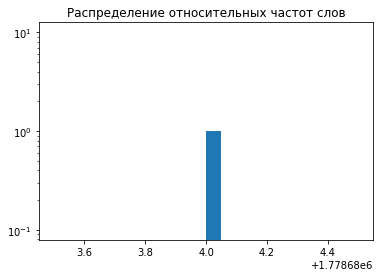

In [229]:
plt.hist(y_counter.getnnz(), bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');
plt.xscale('%');

In [28]:
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


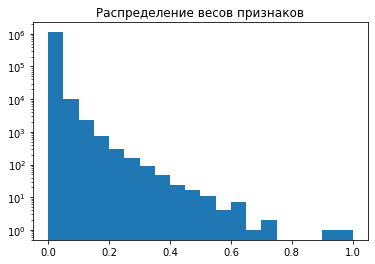

In [29]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

## Распределение классов

In [30]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


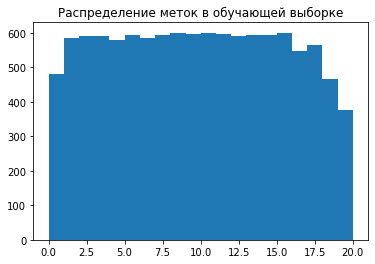

In [31]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

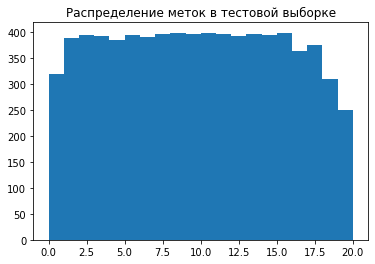

In [32]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

## Обучение модели на PyTorch

In [33]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [36]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Ошибка при обучении: name 'copy_data_to_device' is not defined
Traceback (most recent call last):
  File "<ipython-input-12-df4bbf2ddfff>", line 68, in train_eval_loop
    batch_x = copy_data_to_device(batch_x, device)
NameError: name 'copy_data_to_device' is not defined



In [ ]:

train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

## Альтернативная реализация на scikit-learn

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer()),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

In [25]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

RuntimeError: expected scalar type Long but found Int